## TASK 1 - Rating Prediction via Prompting

#### Model Used: Google Gemini 2.5 Flash
#### Version / Tier: Free tier

#### Yelp Reviews dataset from Kaggle: https://www.kaggle.com/datasets/omkarsabnis/yelp-reviewsdataset

In [63]:
from dotenv import load_dotenv
import os
from google import genai

load_dotenv()
client = genai.Client()  
print("Client initialized successfully!")

Client initialized successfully!


#### This cell initializes the Google Gemini client using a secure API key stored in a .env file. Proper initialization ensures that all prompts can be sent to the LLM consistently and securely.

In [64]:
import pandas as pd
import json
from math import ceil
import time

In [65]:
df = pd.read_csv("yelp.csv")
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


#### This dataset contains Yelp reviews with text, star ratings, and metadata. For Task 1, we use the text as input to our prompts and stars as ground truth to evaluate accuracy. We sample 100 reviews for efficient evaluation of multiple prompting strategies.

In [66]:
df.shape

(10000, 10)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [68]:
df_sample = df.sample(100, random_state=42).reset_index(drop=True)

reviews = df_sample["text"].tolist()
actual_stars = df_sample["stars"].tolist()

#### We sample 100 reviews from the full Yelp dataset to evaluate our prompting approaches efficiently. The reviews list will be used as input to the LLM, and actual_stars will serve as ground truth for accuracy evaluation.

#### We sampled 100 reviews instead of the recommended 200 due to limitations of the free tier, which restricts the number of requests per minute (RPM) and requests per day (RPD), while still allowing meaningful evaluation of the prompting approaches.

### 3 Prompting Approaches

##### The build_prompt function generates three types of prompts to classify Yelp reviews into 1–5 stars. 

##### A. The Direct prompt is a simple instruction-based approach. 
##### B. The Few-Shot prompt includes examples to help the model understand the rating scale. 
##### C. The Guided prompt adds stepwise reasoning to improve consistency and reliability. 

##### All prompts enforce structured JSON output with predicted_stars and explanation.

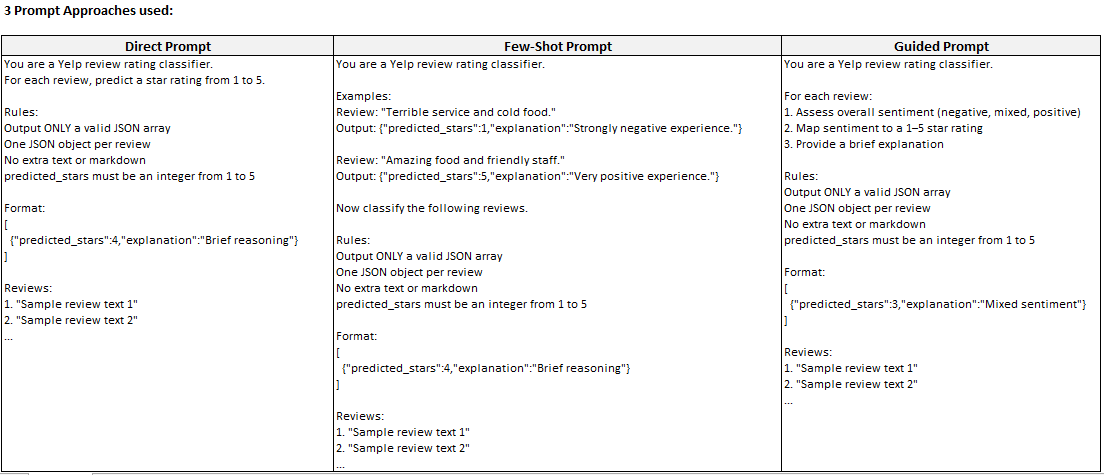

In [69]:
def build_prompt(prompt_type, reviews):

    reviews_text = "\n".join([f"{i+1}. \"{r}\"" for i, r in enumerate(reviews)])

    base_rules = """
Rules:
- Output ONLY a valid JSON array
- One JSON object per review
- No extra text or markdown
- predicted_stars must be an integer from 1 to 5
"""

    if prompt_type == "direct":
        return f"""
You are a Yelp review rating classifier.

For each review, predict a star rating from 1 to 5.

{base_rules}

Format:
[
  {{"predicted_stars":4,"explanation":"Brief reasoning"}}
]

Reviews:
{reviews_text}
"""

    elif prompt_type == "few_shot":
        return f"""
You are a Yelp review rating classifier.

Examples:
Review: "Terrible service and cold food."
Output: {{"predicted_stars":1,"explanation":"Strongly negative experience."}}

Review: "Amazing food and friendly staff."
Output: {{"predicted_stars":5,"explanation":"Very positive experience."}}

Now classify the following reviews.

{base_rules}

Format:
[
  {{"predicted_stars":4,"explanation":"Brief reasoning"}}
]

Reviews:
{reviews_text}
"""

    elif prompt_type == "guided":
        return f"""
You are a Yelp review rating classifier.

For each review:
1. Assess overall sentiment (negative, mixed, positive)
2. Map sentiment to a 1–5 star rating
3. Provide a brief explanation

{base_rules}

Format:
[
  {{"predicted_stars":3,"explanation":"Mixed sentiment"}}
]

Reviews:
{reviews_text}
"""

    else:
        raise ValueError("Invalid prompt type")


In [74]:
import json, re, time

def predict_all(reviews, prompt_type):
    prompt = build_prompt(prompt_type, reviews)

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt
    )

    raw = response.text

    # Non-greedy JSON array extraction
    match = re.search(r'\[.*?\]', raw, re.DOTALL)
    if not match:
        raise ValueError(f"No valid JSON found in response:\n{raw}")

    json_text = match.group(0).rstrip(', \n')
    return json.loads(json_text)


#### The predict_all function sends review prompts to the Google Gemini 2.5 Flash model, which is capable of text classification and structured output generation. 
#### It extracts the JSON array from the model response and returns a list of dictionaries with predicted_stars and explanation. Using a reliable regex ensures that only valid JSON is captured, supporting JSON validity evaluation and consistent results across prompts.

In [75]:
results = {}

print("Running direct prompt...")
results["direct"] = predict_all(reviews, "direct")

time.sleep(30)

print("Running few-shot prompt...")
results["few_shot"] = predict_all(reviews, "few_shot")

time.sleep(30)

print("Running guided prompt...")
results["guided"] = predict_all(reviews, "guided")

Running direct prompt...
Running few-shot prompt...
Running guided prompt...


#### We run each of the three prompting approaches sequentially on the sampled reviews, storing the predictions in a dictionary. 
#### A 30-second pause is added between each prompt to comply with free tier API rate limits. This setup allows us to compare accuracy, JSON validity, and consistency across prompts.

In [76]:
results.keys()

dict_keys(['direct', 'few_shot', 'guided'])

In [77]:
def evaluate(preds, actual):
    valid = 0
    correct = 0

    for i, p in enumerate(preds):
        if isinstance(p, dict) and "predicted_stars" in p:
            valid += 1
            if i < len(actual) and p["predicted_stars"] == actual[i]:
                correct += 1

    return round(correct / len(actual), 3), round(valid / len(actual), 3)

#### The evaluate function calculates two key metrics for each prompting approach: accuracy (how often predicted stars match the actual ratings) and JSON validity (the fraction of predictions that are correctly structured JSON objects). 
#### This allows us to compare the performance and reliability of different prompts.

In [78]:
summary = []

for prompt in ["direct", "few_shot", "guided"]:
    acc, json_rate = evaluate(results[prompt], actual_stars)
    summary.append({
        "Prompt Type": prompt,
        "Accuracy": acc,
        "JSON Validity": json_rate
    })

comparison_df = pd.DataFrame(summary)
comparison_df

,Prompt Type,Accuracy,JSON Validity
0,direct,0.65,1.0
1,few_shot,0.67,1.0
2,guided,0.66,1.0


#### All three prompting strategies produced valid JSON outputs. 
#### 1. Few-Shot achieved the highest accuracy (0.67), likely due to the provided examples guiding the model. 
#### 2. Guided prompts were slightly more accurate than Direct and improve consistency by encouraging stepwise reasoning. 
#### 3. Direct prompts are simpler and faster but slightly less accurate, showing the value of examples and guidance in improving model predictions.

In [79]:
# Optionally, save predictions and comparison
comparison_df.to_csv("prompt_comparison.csv", index=False)

### Structured JSON file output

#### We display the first three predictions from each prompting approach to show that the model returns correctly structured JSON objects. Each output includes predicted_stars and a brief explanation. This allows us to visually inspect reliability and consistency across prompts without overwhelming the notebook with all predictions.

In [80]:
import json

# Display first 3 predictions for each prompt type
for prompt_type in ["direct", "few_shot", "guided"]:
    print(f"=== {prompt_type.capitalize()} Prompt Sample Output ===")
    sample_preds = results[prompt_type][:3]  # first 3 rows
    print(json.dumps(sample_preds, indent=2))
    print("\n")

=== Direct Prompt Sample Output ===
[
  {
    "predicted_stars": 4,
    "explanation": "Despite being empty late, the reviewer enjoyed the food, service, cocktails, and noted positive aspects like happy hour and patio, indicating a good experience overall."
  },
  {
    "predicted_stars": 5,
    "explanation": "The review gives a very strong positive endorsement, stating the crawfish etouffee is the best her friend from Louisiana has had outside her home state."
  },
  {
    "predicted_stars": 3,
    "explanation": "The food is described as 'good and filling' and a regular spot, but also as 'typical strip mall pizza,' suggesting a satisfactory but not outstanding experience."
  }
]


=== Few_shot Prompt Sample Output ===
[
  {
    "predicted_stars": 4,
    "explanation": "Positive experience with food, friendly service, and quality drinks, with minor issues (dead at midnight) being contextualized. Update highlights a great patio."
  },
  {
    "predicted_stars": 5,
    "explanation": "

In [82]:
# Save all predictions per prompt type
for prompt_type in results:
    with open(f"predictions_{prompt_type}.json", "w") as f:
        json.dump(results[prompt_type], f, indent=2)

#### We save all predictions for each prompting approach into separate JSON files. This allows us to inspect or reuse the results later without making additional API calls, ensuring reproducibility and transparency in our evaluation.